# School dataset

In order to reproduce and improve the data regarding the Human Development Index, we need to categorize USs' states by their level of instruction. 
One indicator which may turn to be significant to categorize the level of instruction in each country is probably the average cost of private schools (both for high school and elementary school).
We found an article on the website https://www.privateschoolreview.com/tuition-stats/private-school-cost-by-state which keeps track of these two statistics, and in order to convert the data present on their website to usable data (pandas DataFrame) we need to scrape the information from the web.

In [192]:
from requests import get
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup

We now focus on extracting data from the website  https://www.privateschoolreview.com/tuition-stats/private-school-cost-by-state

## Names of states
First we download the list of names of the US states from the link. 
https://gist.githubusercontent.com/mshafrir/2646763/raw/8b0dbb93521f5d6889502305335104218454c2bf/states_titlecase.json

In [193]:
states_json = pd.read_json('Data/states.json')
states = []

for row in states_json['data']:
    states.append(row['State'])
    
states_df = pd.DataFrame({"State": states})
print(states_df.head())

        State
0     Alabama
1      Alaska
2     Arizona
3    Arkansas
4  California


## Format of the webpage

We noticed that the webpage has the following format: states are listed in a table, and in every row there are 4 tds:
- td[0] is a link with the name of the state
- td[1] is the average tuition
- td[2] is the average high school tuition
- td[3] is the average elementary school tuition

In [194]:
privateschoolreview = ' https://www.privateschoolreview.com/tuition-stats/private-school-cost-by-state'
school_page = get(privateschoolreview)
school_page = BeautifulSoup(school_page.text,'html.parser')

# print(school_page)
table = school_page.find('table', class_='tuition-list')

rows = table.find_all('tr', class_='table_row row_click')

tuition_fees = []

for row in rows:
    if type(row) != 'NoneType':
        tds = row.find_all('td')
        state = tds[0].find('a').text
        high_school_fee = tds[2].text
        elementary_school_fee = tds[3].text
        
        tuition = {
            'State': state,
            'High_School_Fee': high_school_fee,
            'Elementary_School_Fee': elementary_school_fee
        }
        tuition_fees.append(tuition)

tuition_fees_df = pd.DataFrame(tuition_fees)
tuition_fees_df.head()

,State,High_School_Fee,Elementary_School_Fee
0,Alaska,"$6,118","$7,544"
1,Alabama,"$7,633","$6,388"
2,Arkansas,"$6,580","$4,724"
3,Arizona,"$17,339","$6,300"
4,California,"$19,235","$11,360"
5,Colorado,"$14,557","$8,155"
6,Connecticut,"$32,456","$15,929"
7,Delaware,"$10,967","$11,020"
8,Florida,"$9,637","$7,968"
9,Georgia,"$11,793","$9,001"


# Analysis of the data
Before proceeding further, we first check whether all states are listed in the new dataframe.

In [195]:
states_merged = states_df.merge(tuition_fees_df, how='left', right_on='State', left_on='State')
absent_states = states_merged[~states_merged.High_School_Fee.notnull()]
absent_states

,State,High_School_Fee,Elementary_School_Fee
8,District of Columbia,NaN,NaN
34,North Dakota,NaN,NaN
41,South Dakota,NaN,NaN
50,Wyoming,NaN,NaN


We can clearly see that the dataset is not complete, as four states lack the high school and the elementary school average fee.

Let't try to get this data out from the same website: analyzing deeper the website, we discovered that the same data is present on a state basis under the link https://www.privateschoolreview.com/tuition-stats/state-name

The names of the states must be turned into lowercase, substituting whitespaces with character dash ("-").

In [196]:
lowercased_dashed_states = absent_states.State.apply(lambda x: '-'.join(x.lower().split(' ')))
real_names = absent_states.State #[lowercased_dashed_states]

lowercased_dashed_states_df = pd.DataFrame({
    'lowercased_dashed_name': lowercased_dashed_states,
    'real_name': real_names
})

lowercased_dashed_states_df

,lowercased_dashed_name,real_name
8,district-of-columbia,District of Columbia
34,north-dakota,North Dakota
41,south-dakota,South Dakota
50,wyoming,Wyoming


### Then we can scrape the new webpages to look for the missing information:
- The information we are looking for lies in the `div` with `class='school_notes_overview'`
- It is the second `<li>` of an unordered list `<ul>` of `class='highlights_row'` 
- The first price (regex `re'\$\d+(,\d+)?'`) is the elementary school price, and the second price is the high school tuition fee. 

In [197]:
base_url_single_state = 'https://www.privateschoolreview.com/tuition-stats/'

for index, row in lowercased_dashed_states_df.iterrows():
    real_name = row['real_name']
    state_lowercased_dashed = row['lowercased_dashed_name']
    # First get the page
    tuition_per_state = get(base_url_single_state + state_lowercased_dashed)
    html_page_tuition_per_state = BeautifulSoup(tuition_per_state.text,'html.parser')
    
    # find the correct div with class school_notes_overview, and select the <ul> element
    school_notes_overview = html_page_tuition_per_state.find('div', class_='school_notes_overview').find('ul')
    
    # get second <li> of class 'highlights_row'
    second_li = school_notes_overview.find_all('li', class_='highlights_row')[1].text
    print("{}: {}".format(real_name,second_li))
    
    # apply the regex re'\$\d+'
    occurrences = re.findall('\$\d+,\d+', second_li)
    elementary_fee, high_school_fee = occurrences[0], occurrences[1]
    
    new_fee = {
        'State': real_name,
        'High_School_Fee': high_school_fee,
        'Elementary_School_Fee': elementary_fee
    }
    tuition_fees_df.loc[index] = new_fee
    
    

District of Columbia: The private elementary school average is $19,084 per year and the private high school average is $27,337 per year.
North Dakota: The private elementary school average is $2,550 per year and the private high school average is $9,100 per year.
South Dakota: The private elementary school average is $3,029 per year and the private high school average is $6,717 per year.
Wyoming: The private elementary school average is $3,417 per year and the private high school average is $10,575 per year.


### Here we can see that the missing values has been correctly substituted

In [198]:
absent_states.index
tuition_fees_df.loc[absent_states.index]

,State,High_School_Fee,Elementary_School_Fee
8,District of Columbia,"$27,337","$19,084"
34,North Dakota,"$9,100","$2,550"
41,South Dakota,"$6,717","$3,029"
50,Wyoming,"$10,575","$3,417"


## Now we have all the data
We can start converting the input into a more usable format.
For instance, the tuition fee is a string containing the characters `$` followed by a number, with the thousand digits separated by a comma.
We can therefore cast this number to an input.

In [200]:
x = tuition_fees_df.High_School_Fee[0]
high_school_fees = tuition_fees_df.High_School_Fee.apply(lambda x: int("".join(x.split('$')[1].split(','))) )

elementary_school_fees = tuition_fees_df.Elementary_School_Fee.apply(lambda x: int("".join(x.split('$')[1].split(','))) )

tuition_fees_df.High_School_Fee = high_school_fees
tuition_fees_df.Elementary_School_Fee = elementary_school_fees

tuition_fees_df.head()

,State,High_School_Fee,Elementary_School_Fee
0,Alaska,6118,7544
1,Alabama,7633,6388
2,Arkansas,6580,4724
3,Arizona,17339,6300
4,California,19235,11360


# Analysis and description of dataset:
Now that the data is cleaned and complete, we can start developing some statistics over it.
For instance, we may want to plot a chart to show if there are any outliers (fees incredibly high or low).

<BarContainer object of 48 artists>

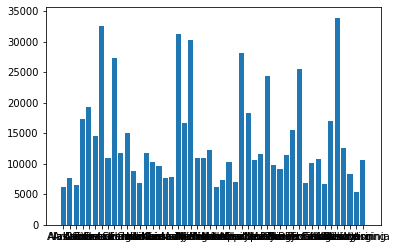

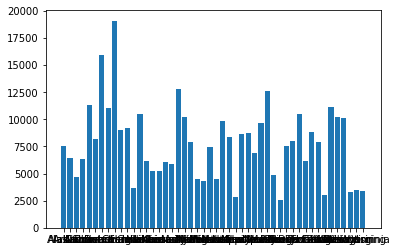

In [203]:
plt.figure(0)
plt.bar(tuition_fees_df.State, tuition_fees_df.High_School_Fee)
plt.figure(1)
plt.bar(tuition_fees_df.State, tuition_fees_df.Elementary_School_Fee)